In [1]:
## FINESSE PACKAGE IMPORTS ##
%matplotlib widget
from ipywidgets import *
import finesse
from finesse.components import Laser, Lens, Mirror, Nothing, Space, Cavity

## INTERNAL PACKAGES ##
from PIL import Image
from pathlib import Path
from pprint import pprint
from itertools import zip_longest, accumulate, cycle, starmap
from functools import reduce
from collections import namedtuple
    
## EXTERNAL PACKAGES ##
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from matplotlib.collections import LineCollection
from matplotlib import colormaps
import numpy as np

## USER PACAKGES ##
# setup_finesse.py IS WHERE I DEFINE ALL THE IMPORTANT FUNCTIONS
from setup_finesse import calculate_nr, setup_simple, setup_cavity_with_crystal, get_relevant_qs, setup_focusing, get_focusing_qs


interactive(children=(FloatSlider(value=0.2, description='L', max=1.0, step=0.01), Dropdown(description='R1 (m…

<function __main__.plot_point(L, R1, R2)>

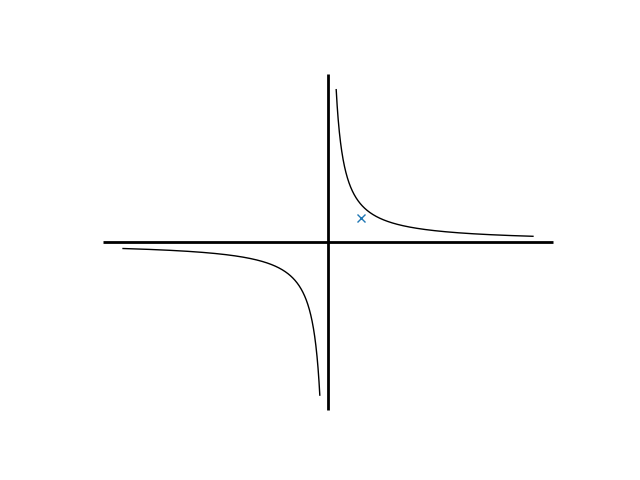

In [2]:
def f(x):
    return 1/x
def g(L, R):
    return (1 - L/R)

plt.close()
figure, axes = plt.subplots()
x_neg = np.linspace(-5, -0.2, 1000)
x_pos = np.linspace(0.2, 5, 1000)

Pos = axes.plot(x_pos,f(x_pos), color="black", linewidth=1)
Neg = axes.plot(x_neg,f(x_neg), color="black", linewidth=1)
X = axes.hlines(0, *axes.get_xlim(), color="black", linewidth=2)
Y = axes.vlines(0, *axes.get_ylim(), color="black", linewidth=2)

point, = axes.plot(g(1, 1), g(1, 1), marker='x', linestyle='')

def plot_point(L, R1, R2):
    point.set_xdata([g(L, R1)])
    point.set_ydata([g(L, 1)])
    

axes.axis("off")
interact(plot_point,
         L=FloatSlider(min=0, max=1, step=0.01, value=0.2),
         R1=Dropdown(options=[50e-3, 100e-3, 150e-3, 200e-3, 1],value=1,description='R1 (m)',disabled=False,),
         R2=Dropdown(options=[50e-3, 100e-3, 150e-3, 200e-3, 1],value=1,description='R2 (m)',disabled=False,)
        )


In [8]:
T = 114.2 #phase matching temperature
nr_crys = calculate_nr(T, 1.55)
nr_crys = 1

start = Laser("L_1550", P=1, f=(300e6)/(1550e-9))

def create_unit_cavity(M, n, unit_props):
    """Creates a unit Model with a crystal, L=20mm, and a Lens representing a mirror, f=0.5m.
    M: finesse.model.Model = cavity's model
    n: int = unit iteration
    unit_props: Dict[str: float] = unit's properties
    """
    
    crystal_length = 20e-3
    crystal_nr = unit_props["crystal_nr"]
    cavity_length = unit_props["cavity_length"]
    f1 = unit_props["f1"]
    f2 = unit_props["f2"]

    half_crystal = crystal_length/2
    crys_lens_length = (cavity_length - crystal_length)/2
    
    prior_units = M.get_open_ports()
    previous_component = prior_units[-1].component.name

    components = [
        Nothing(f"crys_M_a_{n}"),
        Nothing(f"crys_edge_R_a_{n}"),
        Lens(f"m_a_{n}", f=f1),
        Nothing(f"crys_edge_L_b_{n}"),
        Nothing(f"crys_M_b_{n}"),
        Nothing(f"crys_edge_R_b_{n}"),
        Lens(f"m_b_{n}", f=f2),
        Nothing(f"crys_edge_L_a_{n}"),
    ]
    M.add(components)

    M.connect(prior_units[-1].component, components[0], L=half_crystal, nr=1 if previous_component=="laser" else crystal_nr)
    M.connect(components[0], components[1], L=half_crystal, nr=crystal_nr)
    M.connect(components[1], components[2], L=crys_lens_length, nr=1)
    M.connect(components[2], components[3], L=crys_lens_length, nr=1)
    M.connect(components[3], components[4], L=half_crystal, nr=crystal_nr)
    M.connect(components[4], components[5], L=half_crystal, nr=crystal_nr)
    M.connect(components[5], components[6], L=crys_lens_length, nr=1)
    M.connect(components[6], components[7], L=crys_lens_length, nr=1)

    return M


def create_cavity_properties(cavity_length, T_phase_matching, wavelength, f1, f2):
    """Creates the cavity properties: The length, and the crystal's refractive index
    cavity_length: float
    T_phase_matching: float = temperature that the cavity performs the non-linear conversion
    wavelength: float = wavelength that passes through the crystal in microns eg 1550nm == 1.5um
    """
    #calculate_nr(T_phase_matching, wavelength)
    return {"cavity_length": cavity_length, "crystal_nr": 1, "f1": f1, "f2": f2}

def init_model_with_laser(wavelength):

    init_model = finesse.model.Model()
    laser = Laser("laser", P=1)
    init_model.add(laser)
    #init_model.connect(laser, init_model
    
    init_model.lambda0 = wavelength
    return init_model
    
def create_cavity(n_mirrors, cavity_length, unit_properties):

    # initialise #
    Model = init_model_with_laser(1550e-9)

    # create n_mirror amount of unit cavities #
    cavity_model = reduce(lambda model, n: create_unit_cavity(model, n, unit_properties), range(0, n_mirrors), Model)

    return cavity_model

def get_zs(sim):
    zs = zip(*zip(*list(pos for pos in sim.positions.items() for port in ('i', 'o'))[1:]))
    return list(zs)

def get_ws(qs):
    ws = [q.w for q in qs]
    return np.array(ws)

def get_qs(sim):
    qs = zip(*zip(*starmap(lambda node, q: (node.component, q), sim.qs.items())))
    return list(qs)

def filter_for_component(to_filter: zip, name: str):
    filtered = filter(lambda component: name in component[0].name, to_filter)
    components_values = [value for key, value in list(filtered)]
    return np.array(components_values)

def run_simulation(mirror_props, cavity_props, light_props):
    f1 = mirror_props["Rc1"]/2
    f2 = mirror_props["Rc2"]/2

    unit_props = create_cavity_properties(cavity_props["length"], 114.2, light_props["lambda"]*1e6, f1, f2)
    Model = create_cavity(cavity_props["n_units"], cavity_props["length"], unit_props)
    q_i = finesse.gaussian.BeamParam(wavelength=light_props["lambda"], zr=light_props["zR"], z=-10e-3)

    nodes = Model.optical_nodes
    beam_path = Model.path(nodes[1], nodes[-1])
    sim = Model.propagate_beam(path=beam_path, q_in=q_i)

    return sim

def get_results(sim):
    qs = get_qs(sim)
    zs = get_zs(sim)
    results_crys_edge = [filter_for_component(x, "edge") for x in [zs, qs]]

    return {"zs": results_crys_edge[0], "ws": get_ws(results_crys_edge[1])}

In [4]:
cavity_props = {"length": 0.1, "n_units": 20}
mirror_props = {"Rc1": 1, "Rc2": 1}
light_props = {"lambda": 1550e-9, "zR": 20e-3}
sim = run_simulation(mirror_props, cavity_props, light_props)
results = get_results(sim)

Ls = np.arange(25e-3, 100e-3, 2.5e-3)

rayleigh_lengths = np.arange(10e-3, 150e-3, 5e-3)
cavity_properties = [{"length": L, "n_units": 20} for L in Ls]
light_properties = [{"lambda": 1550e-9, "zR": zR} for zR in rayleigh_lengths]

"""
w_results_1000 = []
for light_prop in light_properties:
    max_ws = []
    for cavity_prop in cavity_properties:
        sim = run_simulation(mirror_props, cavity_prop, light_prop)
        results = get_results(sim)
        max_ws.append(results["ws"].max())
    w_results_1000.append(max_ws)

mirror_props_200 = {"Rc1": 1, "Rc2": 200e-3}
w_results_200 = []
for light_prop in light_properties:
    max_ws = []
    for cavity_prop in cavity_properties:
        sim = run_simulation(mirror_props_200, cavity_prop, light_prop)
        results = get_results(sim)
        max_ws.append(results["ws"].max())
    w_results_200.append(max_ws)

mirror_props_50 = {"Rc1": 1, "Rc2": 50e-3}
w_results_50 = []
for light_prop in light_properties:
    max_ws = []
    for cavity_prop in cavity_properties:
        sim = run_simulation(mirror_props_50, cavity_prop, light_prop)
        results = get_results(sim)
        max_ws.append(results["ws"].max())
    w_results_50.append(max_ws)
"""

'\nw_results_1000 = []\nfor light_prop in light_properties:\n    max_ws = []\n    for cavity_prop in cavity_properties:\n        sim = run_simulation(mirror_props, cavity_prop, light_prop)\n        results = get_results(sim)\n        max_ws.append(results["ws"].max())\n    w_results_1000.append(max_ws)\n\nmirror_props_200 = {"Rc1": 1, "Rc2": 200e-3}\nw_results_200 = []\nfor light_prop in light_properties:\n    max_ws = []\n    for cavity_prop in cavity_properties:\n        sim = run_simulation(mirror_props_200, cavity_prop, light_prop)\n        results = get_results(sim)\n        max_ws.append(results["ws"].max())\n    w_results_200.append(max_ws)\n\nmirror_props_50 = {"Rc1": 1, "Rc2": 50e-3}\nw_results_50 = []\nfor light_prop in light_properties:\n    max_ws = []\n    for cavity_prop in cavity_properties:\n        sim = run_simulation(mirror_props_50, cavity_prop, light_prop)\n        results = get_results(sim)\n        max_ws.append(results["ws"].max())\n    w_results_50.append(max_w

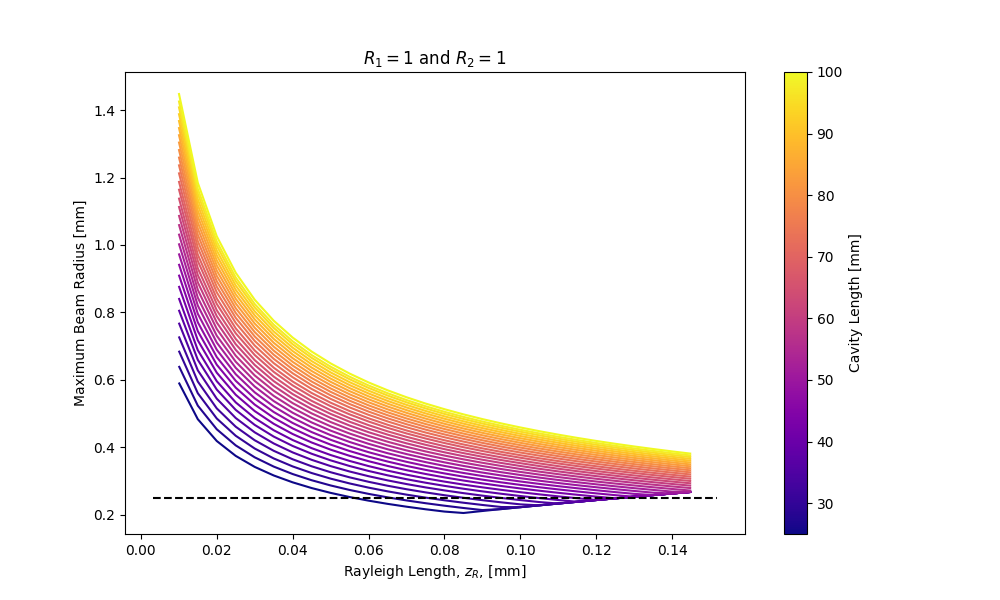

In [306]:
fig, ax = plt.subplots(figsize=(10,6))

xs = rayleigh_lengths
ys = 1000*np.array(w_results_1000)


lines = [list(zip(xs, y)) for y in ys.T]
lc = LineCollection(lines, linewidths=1.5, array=Ls*1000, cmap="plasma")
ax.plot(xs,ys,linewidth=0)
ax.add_collection(lc)
ax.set_xlabel(r"Cavity Length, $L$, [m]")
ax.set_xlabel(r"Rayleigh Length, $z_R$, [mm]")
ax.set_ylabel("Maximum Beam Radius [mm]")
ax.hlines(0.25, *ax.get_xlim(), linestyle='--', color="black")
fig.colorbar(lc, label="Cavity Length [mm]")
ax.set_title(r"$R_1=1$ and $R_2=1$")
plt.show()
# IF L=40e-3, zR=120e-3

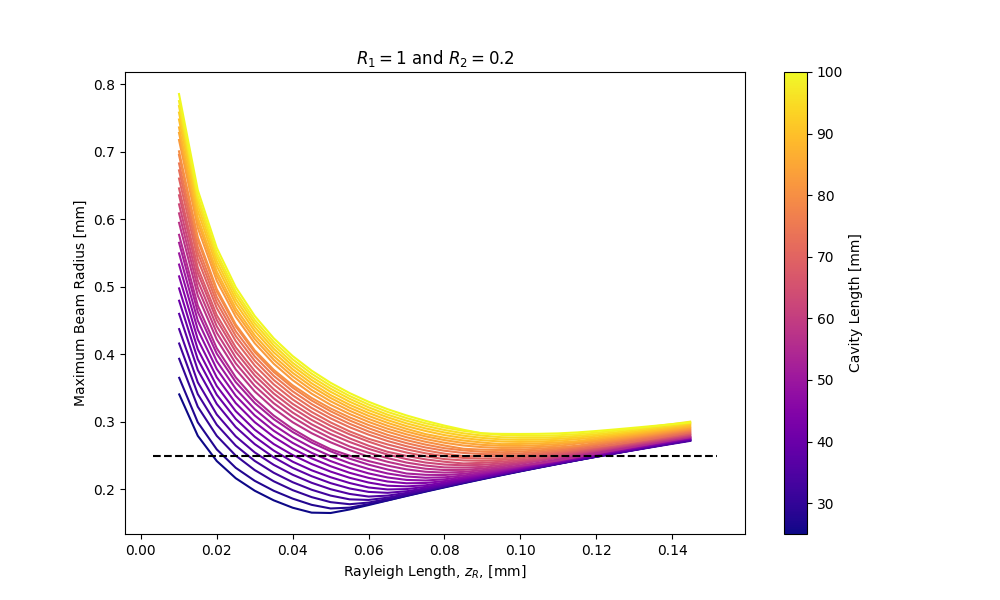

In [307]:
fig, ax = plt.subplots(figsize=(10,6))

xs = rayleigh_lengths
ys = 1000*np.array(w_results_200)

lines = [list(zip(xs, y)) for y in ys.T]
lc = LineCollection(lines, linewidths=1.5, array=Ls*1000, cmap="plasma")
ax.plot(xs,ys,linewidth=0)
ax.add_collection(lc)
ax.set_xlabel(r"Cavity Length, $L$, [m]")
ax.set_xlabel(r"Rayleigh Length, $z_R$, [mm]")
ax.set_ylabel("Maximum Beam Radius [mm]")
ax.hlines(0.25, *ax.get_xlim(), linestyle='--', color="black")
fig.colorbar(lc, label="Cavity Length [mm]")
ax.set_title(r"$R_1=1$ and $R_2=0.2$")

plt.show()

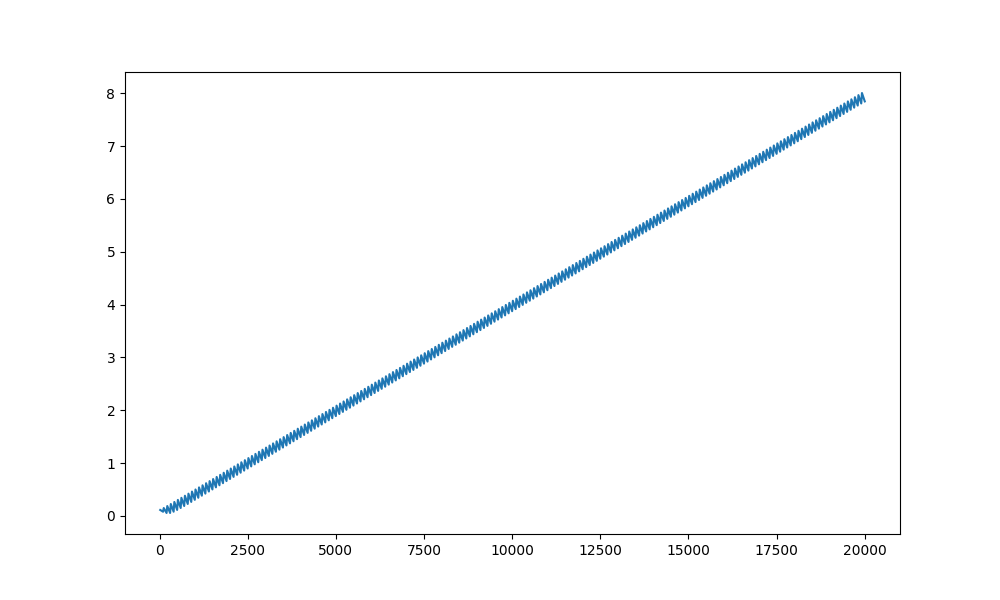

In [9]:
cavity_props = {"length": 0.1, "n_units": 100}
light_props = {"lambda": 1550e-9, "zR": 20e-3}
mirror_props = {"Rc1": 50e-3, "Rc2": 50e-3}
"""
Ls = np.arange(25e-3, 100e-3, 2.5e-3)
mirror_props_50 = {"Rc1": 50e-3, "Rc2": 50e-3}
w_results_50 = []
for light_prop in light_properties:
    max_ws = []
    for cavity_prop in cavity_properties:
        sim = run_simulation(mirror_props_50, cavity_prop, light_prop)
        results = get_results(sim)
        max_ws.append(results["ws"].max())
    w_results_50.append(max_ws)

"""
sim = run_simulation(mirror_props, cavity_props, light_props)
results = get_results(sim)
f, a = plt.subplots(figsize=(10,6))
a.plot(results["zs"]*1000, results["ws"]*1000)
"""
fig, ax = plt.subplots(figsize=(10,6))

xs = rayleigh_lengths
ys = 1000*np.array(w_results_50)

lines = [list(zip(xs, y)) for y in ys.T]
lc = LineCollection(lines, linewidths=1.5, array=Ls*1000, cmap="plasma")
ax.plot(xs,ys,linewidth=0)
ax.add_collection(lc)
ax.set_xlabel(r"Cavity Length, $L$, [m]")
ax.set_xlabel(r"Rayleigh Length, $z_R$, [mm]")
ax.set_ylabel("Maximum Beam Radius [mm]")
ax.hlines(0.25, *ax.get_xlim(), linestyle='--', color="black")
fig.colorbar(lc, label="Cavity Length [mm]")
ax.set_title(r"$R_1=1$ and $R_2=0.05$")
ax.set_ylim(0, 0.45)
"""
plt.show()

interactive(children=(FloatSlider(value=0.2, description='d1', max=1.0, step=0.05), FloatSlider(value=0.2, des…

<function __main__.update(d1, d2, d3, f1, f2)>

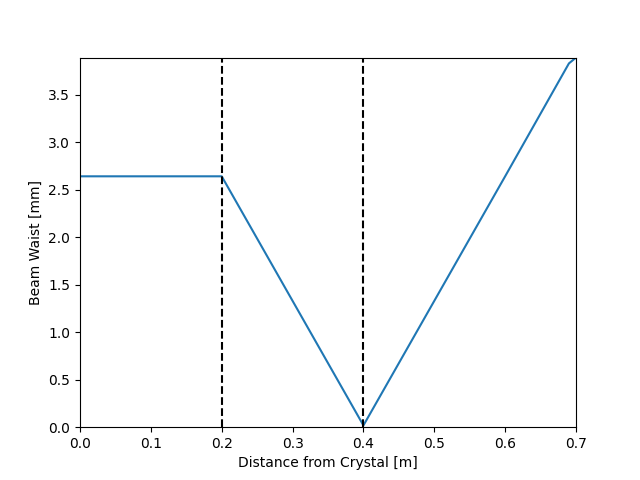

In [5]:
def setup_focusing(wavelen, L, d1, d2, d3, f1, f2, verbose=False, show_graph=False):
    """Setup that includes crystal, cavity input mirror, two lenses and a target to represent the collimator.
    """
    
    M = finesse.model.Model()
    M.lambda0 = wavelen #the beam that focuses down will be 775nm

    start = Laser("start", P=1)

    
    lenses = [Lens("l1", f=f1), Lens("l2", f=f2)]
    cavity_components = [Mirror("m", Rc=-1, R=99.98e-2, T=(100-99.98)*1e-3), Nothing("crys_edge"), Nothing("crys_centre")] #NB: Rc=-1 for back-transmission
    
    M.add([start, lenses, *cavity_components,])

    M.connect(start, lenses[0], name="s_d1", L=d1)
    M.connect(lenses[0], lenses[1], name="s_d2", L=d2)
    M.connect(lenses[1], cavity_components[0], name="s_d3", L=d3)
    M.connect(cavity_components[0], cavity_components[1], name="s_m_edge", L=(cavity_length/2)-10e-3)
    M.connect(cavity_components[1], cavity_components[2], name="s_crys", nr=nr_crys, L=10e-3)

    """
    end = Laser("end", P=1)
    M.add(end)
    M.connect(target, end, name="s_t_end", nr=1, L=1e-3, verbose=verbose)
    """
    if show_graph == True:
        print(M.component_tree())
        M.plot_graph(graphviz=False)

    return M


d1=0.3; d2=0.1; d3=0.2
f1=200e-3; f2=150e-3

def setup_sim(wavelen, cavity_length, d1, d2, d3, f1, f2):
    
    M_focus = setup_focusing(wavelen, cavity_length, d1, d2, d3, f1, f2)
    q_start = finesse.gaussian.BeamParam(wavelength=wavelen, z=9.79e-3, w0=2.64e-3)
    nodes = M_focus.optical_nodes
    beam_path = M_focus.path(nodes[1], nodes[-1])
    sim = M_focus.propagate_beam(path=beam_path, q_in=q_start)

    return sim

wavelen = 775e-9
first_sim = setup_sim(wavelen, cavity_length, d1, d2, d3, f1, f2)
qs = [res[1] for res in get_qs(first_sim)]
zs = [res[1] for res in get_zs(first_sim)]
ws = 1000*get_ws(qs)

#if simfig: plt.close(simfig)
simfig, simax = plt.subplots()
simax.set_xlabel("Distance from Crystal [m]")
simax.set_ylabel("Beam Waist [mm]")

point, = simax.plot(zs, ws , linestyle='-')
l1 = simax.axvline(d1, 0, max(ws), linestyle="--", color="black")
l2 = simax.axvline(d1+d2, 0, max(ws), linestyle="--", color="black")


from time import sleep
def update(d1, d2, d3, f1, f2):

    sim = setup_sim(wavelen,cavity_length, d1, d2, d3, f1, f2)
    qs = [res[1] for res in get_qs(sim)]
    zs = [res[1] for res in get_zs(sim)]
    ws = 1000*get_ws(qs)

    
    point.set_xdata(zs)
    point.set_ydata(ws)
    l1.set_xdata([d1, d1])
    l2.set_xdata([d1+d2, d1+d2])
    simax.set_ylim(0, max(ws))
    simax.set_xlim(0, max(zs))
    



interact(update,
         d1=FloatSlider(min=0, max=1, step=0.05, value=0.2),
         d2=FloatSlider(min=0, max=1, step=0.05, value=0.2),
         d3=FloatSlider(min=0, max=1, step=0.05, value=0.2),
         f1=Dropdown(options=[50e-3, 100e-3, 150e-3, 200e-3],value=200e-3,description='f1 (m)',disabled=False,),
         f2=Dropdown(options=[50e-3, 100e-3, 150e-3, 200e-3],value=150e-3,description='f2 (m)',disabled=False,)
        )
